In [173]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
from submission import Controller
from cobar_miniproject.cobar_fly import CobarFly
from cobar_miniproject import levels
from flygym import SingleFlySimulation, Camera
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np




timestep = 1e-4
debug = True
level = 0
seed = 46

# Initialize fly with all required components
fly = CobarFly(
    debug=debug,
    enable_vision=True,
    render_raw_vision=False,
)

# Create arena with proper parameters for Level 4
arena = levels[level](
    fly=fly, 
    timestep=timestep, 
    seed=seed
)

# Initialize camera
cam_params = {"pos": (0, 0, 80)}
cam = Camera(
    attachment_point=arena.root_element.worldbody,
    camera_name="camera_top_zoomout",
    targeted_fly_names=[fly.name],
    camera_parameters=cam_params,
    play_speed=0.2,
)

# Create simulation
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=timestep,
    arena=arena,
)

# Initialize controller with same timestep
controller = Controller(timestep=timestep, seed=seed)

# Simulation loop with proper error handling
obs, info = sim.reset()

# Verify observation structure - only check for essential keys
required_keys = {'odor_intensity', 'vision'}  # Removed 'heading' requirement
missing_keys = required_keys - set(obs.keys())
if missing_keys:
    raise ValueError(f"Missing required observations: {missing_keys}")

obs_hist = []
info_hist = []
pos_hist = []

max_steps = 30000

try:
    for i in trange(max_steps):
        # Render first to ensure frames are captured
        sim.render()
        
        # Get and validate observations
        obs, reward, terminated, truncated, info = sim.step(controller.get_actions(obs))
        
        # Store history and check termination
        obs_hist.append(obs.copy())
        info_hist.append(info)
        
        if controller.done_level(obs) or controller.quit or arena.quit:
            print("Simulation completed")
            break
            
except Exception as e:
    print(f"Simulation failed: {e}")
    print(f"Last observation keys: {obs.keys() if isinstance(obs, dict) else 'invalid obs'}")
finally:
    if len(obs_hist) > 0:
        save_path = Path("outputs") / f"level{level}_seed{seed}.mp4"
        save_path.parent.mkdir(parents=True, exist_ok=True)
        cam.save_video(save_path, stabilization_time=0)

    #if not obs["vision_updated"]:
    #if "vision" in obs:
    #    del obs["vision"]
    #if "raw_vision" in obs:
    #    del obs["raw_vision"]
    obs_hist.append(obs)
    info_hist.append(info)
    pos_hist.append(controller.get_integrated_position())


    if hasattr(controller, "quit") and controller.quit:
        print("Simulation terminated by user.")
        break
    if hasattr(arena, "quit") and arena.quit:
        print("Target reached. Simulation terminated.")
        break

print(f"Available keys in obs: {list(obs.keys())}")


# Save video
save_path = Path("outputs") / f"level{level}_seed{seed}.mp4"
save_path.parent.mkdir(parents=True, exist_ok=True)
cam.save_video(save_path, stabilization_time=0)

100%|██████████| 30000/30000 [00:48<00:00, 618.28it/s]


Available keys in obs: ['joints', 'end_effectors', 'contact_forces', 'heading', 'velocity', 'fly', 'odor_intensity', 'vision', 'vision_updated', 'reached_odour']


[-1.63491416e-06 -7.30948557e-07]


/tmp/ipykernel_267289/490344740.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


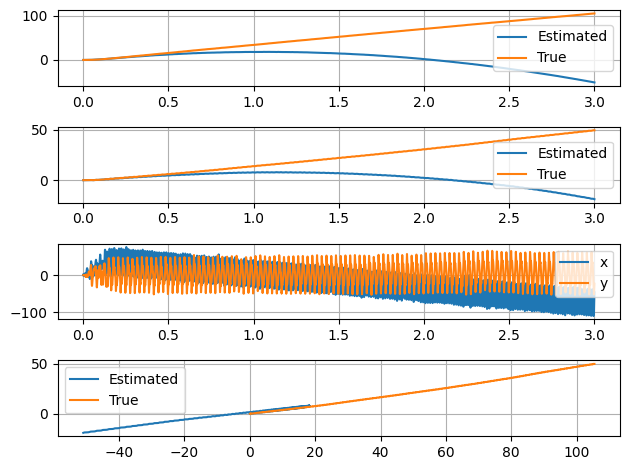

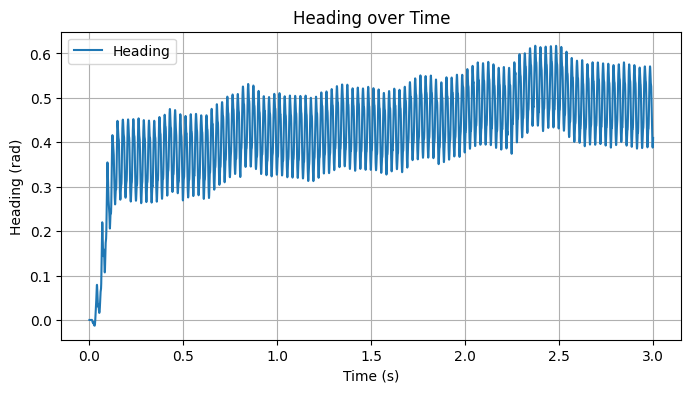

In [175]:
import matplotlib.pyplot as plt
import numpy as np

# Build time vector from controller trace length
times = np.arange(len(obs_hist)) * controller.timestep

true_pos_hist = [obs["fly"][0] for obs in obs_hist]

print(pos_hist[0])

def plot_position_accuracy(pos_hist, true_pos_hist, obs_hist):
    fig, ax = plt.subplots(4, 1)

    ax_x, ax_y, ax_heading, ax_xy = ax.ravel()

    ax_x.plot(times, [pos[0] for pos in pos_hist], label="Estimated")
    ax_x.plot(times, [pos[0] for pos in true_pos_hist], label="True")

    ax_y.plot(times, [pos[1] for pos in pos_hist], label="Estimated")
    ax_y.plot(times, [pos[1] for pos in true_pos_hist], label="True")

    ax_heading.plot(times, [obs["velocity"][0][0] for obs in obs_hist], label="x")
    ax_heading.plot(times, [obs["velocity"][0][1] for obs in obs_hist], label="y")

    ax_xy.plot([pos[0] for pos in pos_hist], [pos[1] for pos in pos_hist], label="Estimated")
    ax_xy.plot([pos[0] for pos in true_pos_hist], [pos[1] for pos in true_pos_hist], label="True")


    for axis in ax.ravel():
        axis.legend()
        axis.grid()


    fig.set_tight_layout(True)
    fig.show()

plot_position_accuracy(pos_hist, true_pos_hist, obs_hist)

plt.figure(figsize=(8, 4))
plt.plot(times, [obs["heading"] for obs in obs_hist], label="Heading")
plt.xlabel("Time (s)")
plt.ylabel("Heading (rad)")
plt.title("Heading over Time")
plt.legend()
plt.grid(True)
plt.show()

In [63]:
def plot_heading(obs_hist):
    times = np.arange(len(obs_hist)) * controller.timestep
    fig, ax = plt.subplots()
    ax.plot(times, [obs['heading'] for obs in obs_hist])

/tmp/ipykernel_267289/1876299627.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis.legend()
/tmp/ipykernel_267289/1876299627.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


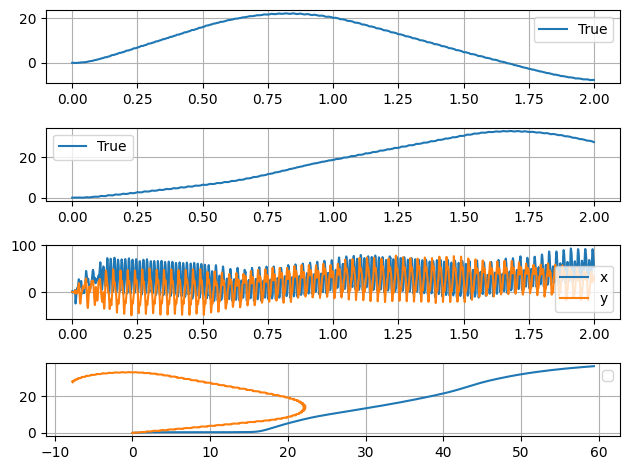

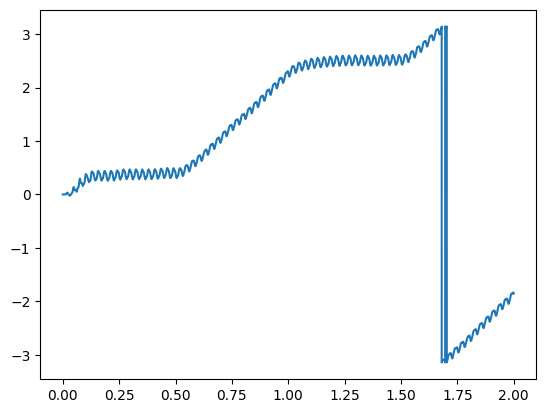

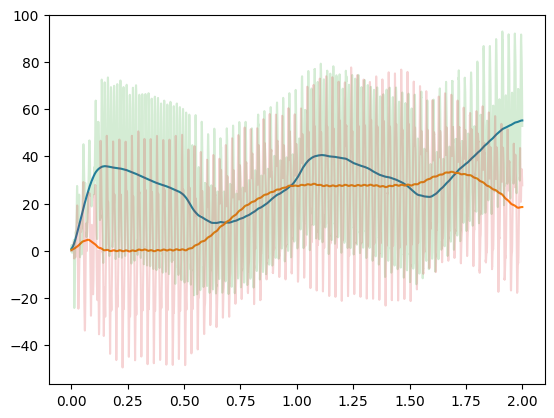

In [161]:
from scipy.signal import filtfilt, butter

integrated_position = np.zeros(2)
pos_hist = []
rotated_vels = []

fs = 1 / timestep  # Sampling frequency (Hz)
cutoff = 1 / 0.1  # Cutoff frequency (Hz)
nyq = 0.5 * fs
wn = cutoff / nyq  # Normalized cutoff frequency

b_lpf, a_lpf = butter(N=2, Wn=wn, btype='low')

# Apply filter to velocity
vel = [np.array(obs["velocity"].ravel())[0] for obs in obs_hist]
vel_lpf_x = filtfilt(b_lpf, a_lpf, vel)
vel = [np.array(obs["velocity"].ravel())[1] for obs in obs_hist]
vel_lpf_y = filtfilt(b_lpf, a_lpf, vel)

vel_lpf = np.vstack([vel_lpf_x, vel_lpf_y]).T


for i, observation in enumerate(obs_hist): 
    vel = observation["velocity"]
    heading = observation["heading"]
    heading = -heading
    vel = vel_lpf[i]
    # Design a low-pass Butterworth filter with cutoff at 0.01 seconds

    rot_matrix = np.array(
            [
                [np.cos(heading), -np.sin(heading)],
                [np.sin(heading), np.cos(heading)]
            ]
    )

    rot_matrix = np.eye(2)

    rotated_vel = vel @ rot_matrix
    rotated_vels.append(rotated_vel.copy())

    # rot_matrix = np.eye(2)
    integrated_position += (rotated_vel) * 1e-4
    pos_hist.append(integrated_position.copy())


plot_position_accuracy(pos_hist, true_pos_hist, obs_hist)
plot_heading(obs_hist)

fig, ax = plt.subplots()

ax.plot(times, rotated_vels)
ax.plot(times, [obs["velocity"].ravel() for obs in obs_hist], alpha=0.2)


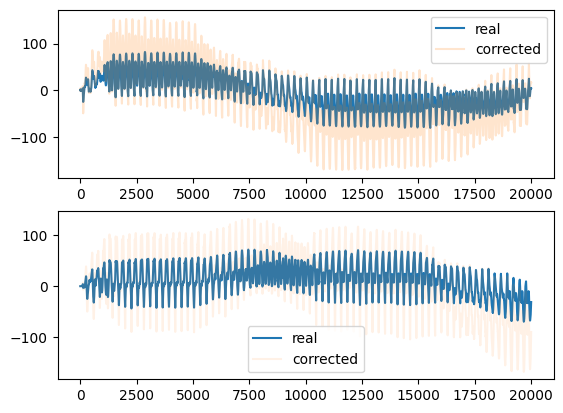

In [127]:
def relative_to_absolute_pos(
    rel_pos: np.ndarray, base_pos: np.ndarray, heading_angle: float
) -> np.ndarray:
    rot_matrix_inv = np.array(
        [
            [np.cos(-heading_angle), np.sin(-heading_angle)],
            [-np.sin(-heading_angle), np.cos(-heading_angle)],
        ]
    )
    
    # Apply inverse rotation and then add the base position
    abs_pos = (rel_pos @ rot_matrix_inv) + base_pos
    
    return abs_pos

real_vels = []
corrected_vels = []

for obs in obs_hist:
    corrected_vel = relative_to_absolute_pos(obs["velocity"].ravel(), obs["fly"][1][0:2], -obs["heading"])
    real_vels.append(obs["fly"][1][0:2])
    corrected_vels.append(corrected_vel)

fig, axes = plt.subplots(2, 1)
ax_x, ax_y = axes.ravel()
ax_x.plot([real_vel[0] for real_vel in real_vels], label="real")
ax_x.plot([corrected_vel[0] for corrected_vel in corrected_vels], label="corrected", alpha=0.2)

ax_y.plot([real_vel[1] for real_vel in real_vels], label="real")
ax_y.plot([corrected_vel[1] for corrected_vel in corrected_vels], label="corrected", alpha=0.1)

for ax in axes.ravel():
    ax.legend()
    

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Estimated trajectory
estimated = np.array(controller.position_trace)

# True trajectory: extract first row from obs["fly"] (x, y, z), keep only x and y
true_points = []
for obs in obs_hist:
    try:
        if "fly" in obs:
            pos = obs["fly"][0]  # First row: position
            if isinstance(pos, (list, tuple, np.ndarray)) and len(pos) >= 2:
                true_points.append([pos[0], pos[1]])
    except Exception:
        continue

true = np.array(true_points)

# Plot
plt.figure(figsize=(8, 6))
if len(true) > 0:
    plt.plot(true[:, 0], true[:, 1], label="True trajectory", color="black", linewidth=2)
if len(estimated) > 0:
    plt.plot(estimated[:, 0], estimated[:, 1], label="Estimated trajectory", color="red", linestyle="--", linewidth=1.5)






plt.xlabel("X position (mm)")
plt.ylabel("Y position (mm)")
plt.title("Fly Trajectory: Estimated vs. True")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


Plot x et y enb fct du temps 

In [ ]:
#plot of the odor intensity 
import matplotlib.pyplot as plt
import numpy as np

print(obs_hist[0]["odor_intensity"])    


     
odor_left = [((obs["odor_intensity"][0][0] + obs["odor_intensity"][0][2]))/2 for obs in obs_hist]
odor_right = [((obs["odor_intensity"][0][1] + obs["odor_intensity"][0][3]))/2 for obs in obs_hist]

plt.plot(odor_left, label="Left Odor Intensity")
plt.plot(odor_right, label="Right Odor Intensity")


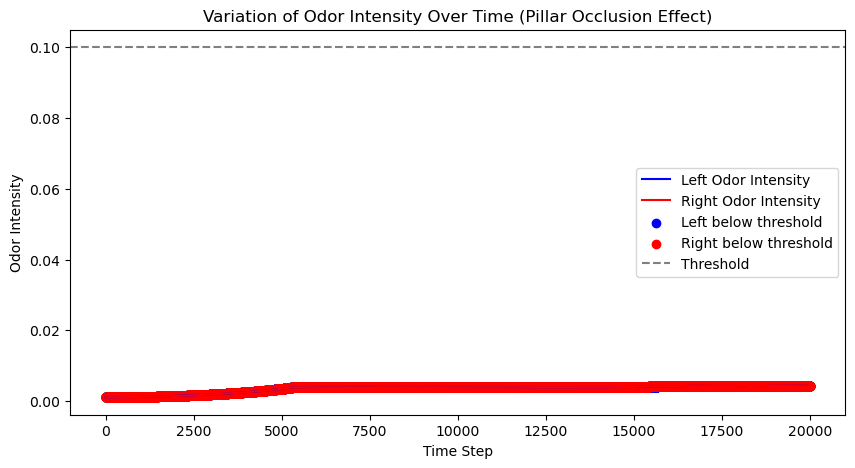

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the threshold used in the controller (assumed occlusion indicator).
ODOR_THRESHOLD = 0.1

# Compute the mean odor intensities for left and right sensors over time.
odor_left = [((obs["odor_intensity"][0][0] + obs["odor_intensity"][0][2]))/2 for obs in obs_hist]
odor_right = [((obs["odor_intensity"][0][1] + obs["odor_intensity"][0][3]))/2 for obs in obs_hist]

# Create a time vector.
time_steps = np.arange(len(obs_hist))

# Plot the odor intensity curves.
plt.figure(figsize=(10, 5))
plt.plot(time_steps, odor_left, label="Left Odor Intensity", color="blue")
plt.plot(time_steps, odor_right, label="Right Odor Intensity", color="red")

# Mark the time steps where the odor intensity drops below the threshold.
left_low = [i for i, intensity in enumerate(odor_left) if intensity < ODOR_THRESHOLD]
right_low = [i for i, intensity in enumerate(odor_right) if intensity < ODOR_THRESHOLD]
plt.scatter(left_low, [odor_left[i] for i in left_low], color="blue", marker="o", 
            label="Left below threshold")
plt.scatter(right_low, [odor_right[i] for i in right_low], color="red", marker="o", 
            label="Right below threshold")

# Plot a horizontal line at the threshold.
plt.axhline(ODOR_THRESHOLD, color='gray', linestyle='--', label="Threshold")

plt.xlabel("Time Step")
plt.ylabel("Odor Intensity")
plt.title("Variation of Odor Intensity Over Time (Pillar Occlusion Effect)")
plt.legend()
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Define the parameters (same as used in controller.py)
# avoidance_distance = 5.0  # threshold distance for pillar effect
# aversive_gain = 80    # tuning parameter for pillar aversion

# # Compute pillar bias history
# pillar_bias_history = []
# for obs in obs_hist:
#     bias = 0.0
#     for pillar in obs.get("pillars", []):
#         pos = pillar.get("position", None)
#         if pos:
#             dist = np.hypot(pos[0], pos[1])
#             if dist < avoidance_distance:
#                 factor = 1 - (dist / avoidance_distance)
#                 # Negative bias for pillars on the left, positive for right.
#                 if pos[0] < 0:
#                     bias -= aversive_gain * factor
#                 else:
#                     bias += aversive_gain * factor
#     pillar_bias_history.append(bias)

# print(obs_hist[0].keys())
# print(obs_hist[0].get("pillars", []))

# plt.figure(figsize=(8,4))
# plt.plot(pillar_bias_history, label="Pillar Aversive Bias")
# plt.xlabel("Time step")
# plt.ylabel("Bias value")
# plt.title("Pillar Aversive Bias Over Time")
# plt.legend()
# plt.show()

I verify the keys i can use

In [ ]:
from cobar_miniproject.cobar_fly import CobarFly
from cobar_miniproject import levels
from flygym import SingleFlySimulation

# Loop through levels 0 to 5.
for lvl in range(5):
    print(f"--- Level {lvl} ---")
    # Instantiate the fly.
    fly = CobarFly(debug=False, enable_vision=False, render_raw_vision=False)
    
    # Create the arena using the corresponding level.
    if lvl <= 1:
        arena = levels[lvl](fly=fly, seed=4)
    else:
        arena = levels[lvl](fly=fly, timestep=1e-4, seed=4)
    
    # Create a simulation without cameras (for faster reset).
    sim = SingleFlySimulation(fly=fly, arena=arena, timestep=1e-4, cameras=[])  
    obs, _ = sim.reset()
    
    # Print observation dictionary keys.
    print("Observation keys:", list(obs.keys()))
    print()  # Empty line for clarity.

--- Level 0 ---
Observation keys: ['joints', 'end_effectors', 'contact_forces', 'heading', 'velocity', 'odor_intensity']

--- Level 1 ---
Observation keys: ['joints', 'end_effectors', 'contact_forces', 'heading', 'velocity', 'odor_intensity']

--- Level 2 ---
Observation keys: ['joints', 'end_effectors', 'contact_forces', 'heading', 'velocity', 'odor_intensity']

--- Level 3 ---
Observation keys: ['joints', 'end_effectors', 'contact_forces', 'heading', 'velocity', 'odor_intensity']

--- Level 4 ---
Observation keys: ['joints', 'end_effectors', 'contact_forces', 'heading', 'velocity', 'odor_intensity']

